# Data Exploration - Legal Text Decoder

This notebook explores the preprocessed dataset for the Legal Text Decoder project.

**Dataset Overview:**
- Hungarian legal texts (ÁSZF - Általános Szerződési Feltételek)
- Labeled for understandability on a scale of 1-5
- Data collected from multiple students using Label Studio

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

## 1. Load the Preprocessed Data

In [2]:
# Load all data
with open('../data/processed/all_data.json', 'r', encoding='utf-8') as f:
    all_data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(all_data)
print(f"Total samples: {len(df)}")
df.head()

Total samples: 3397


,text,label,source_folder,source_file
0,Hacsak jelen Általános Szerződési Feltételek (...,5,WFXBHI,libri_aszf.json
1,"Felhasználó: az a természetes személy, jogi sz...",4,WFXBHI,libri_aszf.json
2,Fogyasztó: a Polgári Törvénykönyvben meghatáro...,1,WFXBHI,libri_aszf.json
3,"Termék: áru vagy szolgáltatás, ideértve az ing...",2,WFXBHI,libri_aszf.json
4,"Áru: ingó dolog, amely digitális tartalmat vag...",1,WFXBHI,libri_aszf.json


In [3]:
# Basic info
print("Dataset Info:")
print(f"  Columns: {list(df.columns)}")
print(f"  Total samples: {len(df)}")
print(f"  Source folders: {df['source_folder'].nunique()}")
print(f"  Source files: {df['source_file'].nunique()}")

Dataset Info:
  Columns: ['text', 'label', 'source_folder', 'source_file']
  Total samples: 3397
  Source folders: 25
  Source files: 30


## 2. Label Distribution Analysis

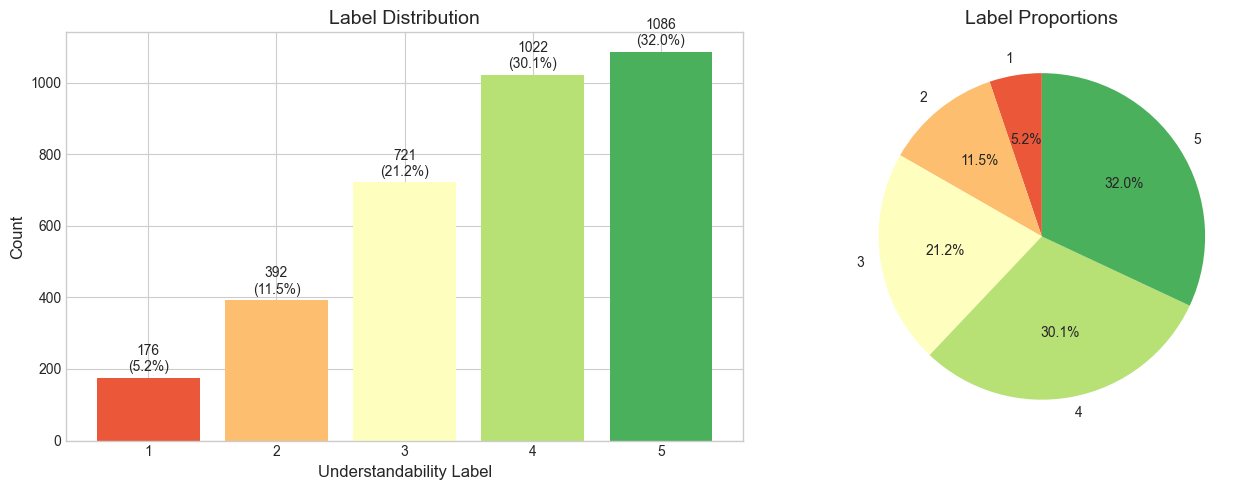


Label counts:
  1-Nagyon nehezen érthető: 176 (5.2%)
  2-Nehezen érthető: 392 (11.5%)
  3-Többé/kevésbé megértem: 721 (21.2%)
  4-Érthető: 1022 (30.1%)
  5-Könnyen érthető: 1086 (32.0%)


In [4]:
# Label distribution
label_counts = df['label'].value_counts().sort_index()
label_names = {
    1: '1-Nagyon nehezen érthető',
    2: '2-Nehezen érthető',
    3: '3-Többé/kevésbé megértem',
    4: '4-Érthető',
    5: '5-Könnyen érthető'
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = sns.color_palette('RdYlGn', 5)
bars = axes[0].bar(label_counts.index, label_counts.values, color=colors)
axes[0].set_xlabel('Understandability Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Label Distribution', fontsize=14)
axes[0].set_xticks([1, 2, 3, 4, 5])

# Add value labels on bars
for bar, count in zip(bars, label_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                 f'{count}\n({100*count/len(df):.1f}%)', 
                 ha='center', va='bottom', fontsize=10)

# Pie chart
axes[1].pie(label_counts.values, labels=[f'{i}' for i in label_counts.index], 
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Label Proportions', fontsize=14)

plt.tight_layout()
plt.savefig('../notebook/label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nLabel counts:")
for label, count in label_counts.items():
    print(f"  {label_names[label]}: {count} ({100*count/len(df):.1f}%)")

## 3. Text Length Analysis

In [5]:
# Add text length columns
df['text_length_chars'] = df['text'].str.len()
df['text_length_words'] = df['text'].str.split().str.len()

# Text length statistics
print("Text Length Statistics (characters):")
print(df['text_length_chars'].describe())

print("\nText Length Statistics (words):")
print(df['text_length_words'].describe())

Text Length Statistics (characters):
count    3397.000000
mean      405.414189
std       455.847936
min         2.000000
25%       173.000000
50%       309.000000
75%       498.000000
max      9223.000000
Name: text_length_chars, dtype: float64

Text Length Statistics (words):
count    3397.000000
mean       50.407124
std        56.456692
min         1.000000
25%        21.000000
50%        38.000000
75%        62.000000
max      1186.000000
Name: text_length_words, dtype: float64


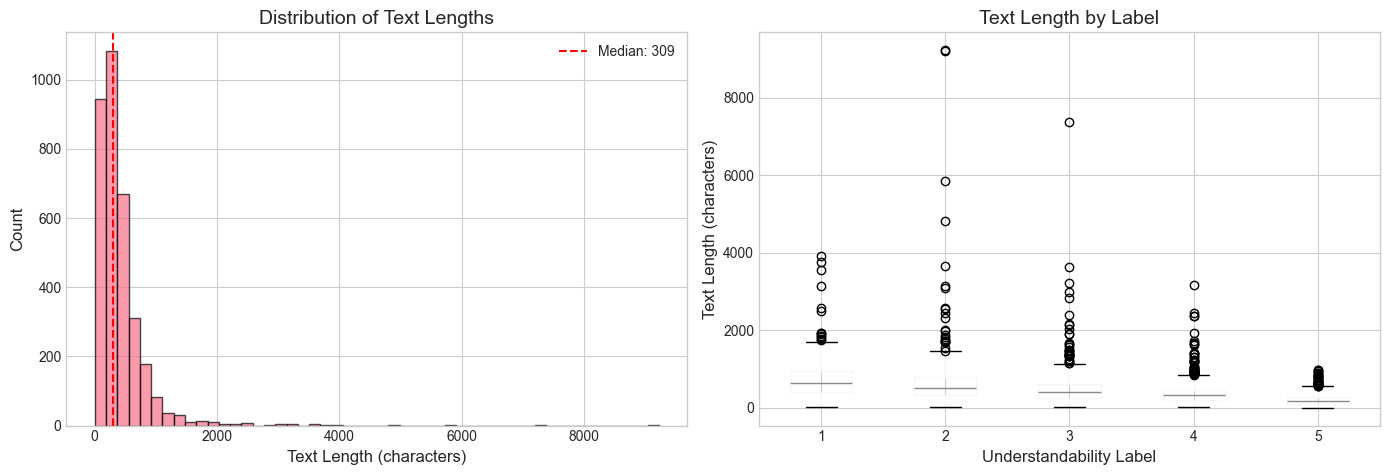

In [6]:
# Text length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of character lengths
axes[0].hist(df['text_length_chars'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Text Length (characters)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Text Lengths', fontsize=14)
axes[0].axvline(df['text_length_chars'].median(), color='red', linestyle='--', label=f'Median: {df["text_length_chars"].median():.0f}')
axes[0].legend()

# Box plot by label
df.boxplot(column='text_length_chars', by='label', ax=axes[1])
axes[1].set_xlabel('Understandability Label', fontsize=12)
axes[1].set_ylabel('Text Length (characters)', fontsize=12)
axes[1].set_title('Text Length by Label', fontsize=14)
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.savefig('../notebook/text_length_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# Text length by label
print("\nMean text length (chars) by label:")
for label in sorted(df['label'].unique()):
    mean_len = df[df['label'] == label]['text_length_chars'].mean()
    print(f"  Label {label}: {mean_len:.1f} chars")


Mean text length (chars) by label:
  Label 1: 768.3 chars
  Label 2: 692.1 chars
  Label 3: 495.4 chars
  Label 4: 378.1 chars
  Label 5: 209.1 chars


## 5. Sample Examples

In [8]:
# Show examples from each label
print("Sample texts for each understandability level:\n")
print("="*80)

for label in sorted(df['label'].unique()):
    sample = df[df['label'] == label].sample(1).iloc[0]
    print(f"\n[LABEL {label}: {label_names[label]}]")
    print("-"*80)
    text = sample['text']
    # Truncate long texts
    if len(text) > 500:
        text = text[:500] + "..."
    print(text)
    print(f"\nSource: {sample['source_folder']}/{sample['source_file']}")
    print(f"Length: {len(sample['text'])} chars")
    print("="*80)

Sample texts for each understandability level:


[LABEL 1: 1-Nagyon nehezen érthető]
--------------------------------------------------------------------------------
Bizottság rendelete: az EU 2018/1972 európai parlamenti és tanácsi irányelv alapján a nyilvánosan elérhető elektronikus hírközlési szolgáltatásokat nyújtó szolgáltatók által használandó szerződésösszefoglaló minta létrehozásáról.

Source: EKGPBX/project-29-at-2025-10-16-16-34-dc747442.json
Length: 229 chars

[LABEL 2: 2-Nehezen érthető]
--------------------------------------------------------------------------------
Felhasználó a Megrendelés (III.1.b.) és az Adatbeviteli hibáknak a szerződéses nyilatkozat elküldését megelőzően történő azonosításához és kijavításához biztosított eszközökkel kapcsolatos tájékoztatás (III.1.d.) pontban foglaltak szerint tudja megadni, ellenőrizni, pontosítani és módosítani rendelése adatait, így a számla kötelező elemét képező adószámát is.

Source: WFXBHI/libri_aszf.json
Length: 361 chars

[

## 6. Train/Val/Test Split Verification

In [9]:
# Load splits
splits = {}
for split_name in ['train', 'val', 'test']:
    with open(f'../data/processed/{split_name}.json', 'r', encoding='utf-8') as f:
        splits[split_name] = pd.DataFrame(json.load(f))

# Verify split sizes
print("Split sizes:")
for name, split_df in splits.items():
    print(f"  {name}: {len(split_df)} ({100*len(split_df)/len(df):.1f}%)")

# Check for data leakage (no overlap between splits)
train_texts = set(splits['train']['text'])
val_texts = set(splits['val']['text'])
test_texts = set(splits['test']['text'])

train_val_overlap = len(train_texts.intersection(val_texts))
train_test_overlap = len(train_texts.intersection(test_texts))
val_test_overlap = len(val_texts.intersection(test_texts))

print(f"\nData leakage check:")
print(f"  Train-Val overlap: {train_val_overlap}")
print(f"  Train-Test overlap: {train_test_overlap}")
print(f"  Val-Test overlap: {val_test_overlap}")

Split sizes:
  train: 2714 (79.9%)
  val: 338 (9.9%)
  test: 345 (10.2%)

Data leakage check:
  Train-Val overlap: 0
  Train-Test overlap: 0
  Val-Test overlap: 0


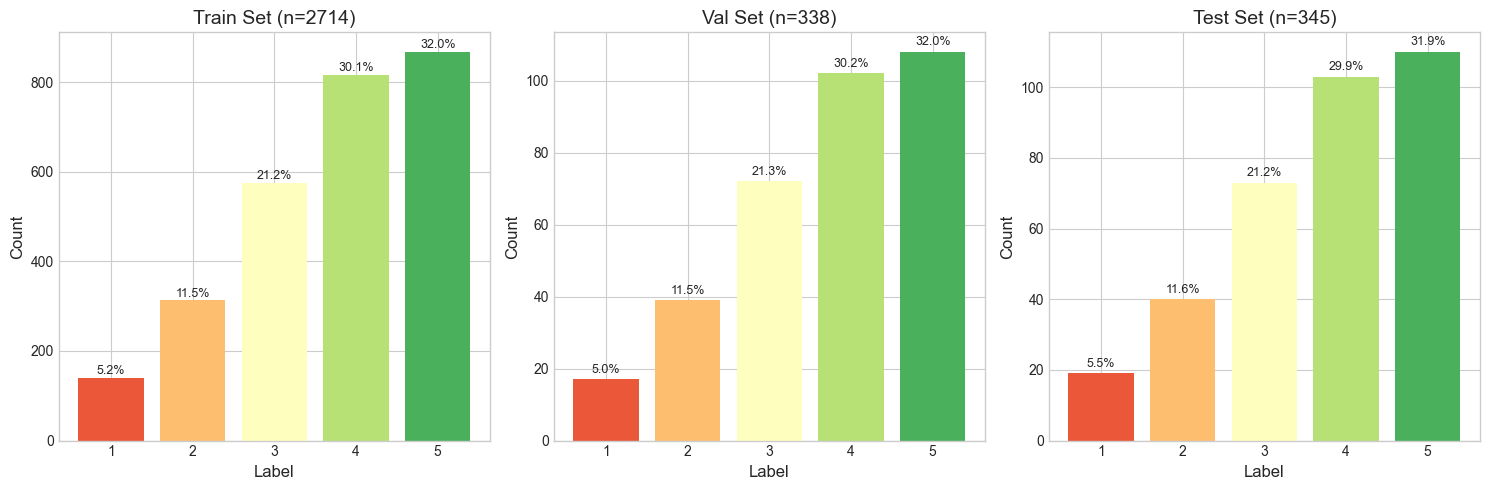

In [10]:
# Label distribution across splits
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (name, split_df) in enumerate(splits.items()):
    counts = split_df['label'].value_counts().sort_index()
    colors = sns.color_palette('RdYlGn', 5)
    axes[i].bar(counts.index, counts.values, color=colors)
    axes[i].set_xlabel('Label', fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].set_title(f'{name.capitalize()} Set (n={len(split_df)})', fontsize=14)
    axes[i].set_xticks([1, 2, 3, 4, 5])
    
    # Add percentage labels
    for j, (label, count) in enumerate(counts.items()):
        axes[i].text(label, count + 1, f'{100*count/len(split_df):.1f}%', 
                     ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../notebook/split_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary Statistics

In [11]:
# Summary table
summary = {
    'Metric': [
        'Total Samples',
        'Training Samples',
        'Validation Samples',
        'Test Samples',
        'Number of Labels',
        'Source Folders',
        'Min Text Length (chars)',
        'Max Text Length (chars)',
        'Mean Text Length (chars)',
        'Median Text Length (chars)',
    ],
    'Value': [
        len(df),
        len(splits['train']),
        len(splits['val']),
        len(splits['test']),
        df['label'].nunique(),
        df['source_folder'].nunique(),
        df['text_length_chars'].min(),
        df['text_length_chars'].max(),
        f"{df['text_length_chars'].mean():.1f}",
        f"{df['text_length_chars'].median():.0f}",
    ]
}

summary_df = pd.DataFrame(summary)
print("\nDataset Summary:")
print(summary_df.to_string(index=False))


Dataset Summary:
                    Metric Value
             Total Samples  3397
          Training Samples  2714
        Validation Samples   338
              Test Samples   345
          Number of Labels     5
            Source Folders    25
   Min Text Length (chars)     2
   Max Text Length (chars)  9223
  Mean Text Length (chars) 405.4
Median Text Length (chars)   309
